# dlt plugin for Hamilton
This notebook shows how to use Hamilton [materializers](https://hamilton.dagworks.io/en/latest/concepts/materialization/) to move data between Hamilton and dlt.

Content:
1. Defining an illustrative Hamilton dataflow
2. `DataSaver`: save Hamilton results to a [dlt Destination](https://dlthub.com/docs/dlt-ecosystem/destinations/)
3. `DataLoader`: load data from a [dlt Resource](https://dlthub.com/docs/dlt-ecosystem/verified-sources/) (a single table from a Source) into a Hamilton node

In [1]:
%load_ext hamilton.plugins.jupyter_magic

import dlt
from hamilton import driver
from hamilton.io.materialization import to, from_
from hamilton.plugins import dlt_extensions

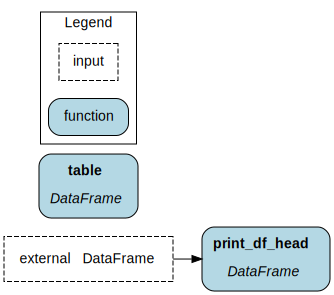

In [2]:
%%cell_to_module -m my_module -d
import pandas as pd

def table() -> pd.DataFrame:
    return pd.DataFrame([{"C": 1}, {"C": 2}])

def print_df_head(external: pd.DataFrame) -> pd.DataFrame:
    print("from print_df_head:\n", external.head())

In [3]:
dr = driver.Builder().with_modules(my_module).build()

## DataSaver
With "Extract, Transform, Load" (ETL) as frame of reference, here, the Hamilton dataflow is responsible for Transform, and `DltDestination` for Load.


Start by defining a dlt `Pipeline` that uses your chosen dlt Destination. This is regular dlt code that you will pass to Hamilton.

In [4]:
saver_pipeline = dlt.pipeline(pipeline_name="saver_pipe", destination="duckdb")

### Single dependency
Define the materializer with `to.dlt()` the example below shows required arguments. You specify an `id` for the materializer and `dependencies` includes the name of a single Hamilton node. Then, specify a `table_name` for the destination and pass the `pipeline`. 

The [other keyword arguments](https://dlthub.com/docs/api_reference/pipeline/__init__#run) for `dlt.pipeline.run()` are accepted and allow specifying incremental loading, table schema annotation, and more.

{'pipeline': {'pipeline_name': 'saver_pipe'}, 'metrics': [{'started_at': DateTime(2024, 4, 14, 21, 56, 41, 147097, tzinfo=Timezone('UTC')), 'finished_at': DateTime(2024, 4, 14, 21, 56, 41, 320724, tzinfo=Timezone('UTC')), 'load_id': '1713131800.765432'}], 'destination_type': 'dlt.destinations.duckdb', 'destination_displayable_credentials': 'duckdb:////home/tjean/projects/dagworks/hamilton/examples/dlt/saver_pipe.duckdb', 'destination_name': 'duckdb', 'environment': None, 'staging_type': None, 'staging_name': None, 'staging_displayable_credentials': None, 'destination_fingerprint': '', 'dataset_name': 'saver_pipe_dataset', 'loads_ids': ['1713131800.765432'], 'load_packages': [{'load_id': '1713131800.765432', 'package_path': '/home/tjean/.dlt/pipelines/saver_pipe/load/loaded/1713131800.765432', 'state': 'loaded', 'completed_at': DateTime(2024, 4, 14, 21, 56, 41, 306600, tzinfo=Timezone('UTC')), 'jobs': [{'state': 'completed_jobs', 'file_path': '/home/tjean/.dlt/pipelines/saver_pipe/load/

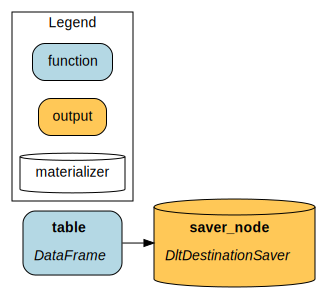

In [5]:
materializers = [
    to.dlt(
        id="saver_node",
        dependencies=["table"],
        table_name="my_table",
        pipeline=saver_pipeline,
    )
]
metadata, _ = dr.materialize(*materializers)
print(metadata["saver_node"])
dr.visualize_materialization(*materializers)

## DataLoader
With ETL as a frame of reference, the `DataLoader` uses dlt to run the "Extract" step for the passed dlt `Resource`. 

Internally, it creates a temporary dlt Pipeline to run the extract and normalize steps then reads the files in-memory. The dlt Pipeline is then deleted. 

In [6]:
# this is a mock dlt Source for demo purposes

from typing import Iterable
from dlt.extract import DltResource
from dlt.common.typing import TDataItem

@dlt.source
def mock_source() -> Iterable[DltResource]:
    iterable_data = [{"col": 1}, {"col": 2}, {"col": 3}] * 100
    
    @dlt.resource
    def mock_resource() -> Iterable[TDataItem]:
        yield from iterable_data
        
    yield mock_resource
        
        
my_mock_source = mock_source()

### Single resource
To define the materializer, give it a `target` Hamilton node and pass a dlt Resource to `resource`. When working with a dlt Source, you can access individual resources via the dictionary `Source.resource[RESOURCE_NAME]`

In [7]:
materializers = [
    from_.dlt(
        target="external",
        resource=my_mock_source.resources["mock_resource"],
    ),
]

metadata, _ = dr.materialize(
    *materializers,
    additional_vars=["print_df_head"]
)

from print_df_head:
    col        _dlt_load_id         _dlt_id
0    1  1713131801.3954566  pIOVDF0PSQez4g
1    2  1713131801.3954566  V39tnCZ5OHJS8A
2    3  1713131801.3954566  Neg2YxZXqbtDdg
3    1  1713131801.3954566  18GzdWmzRuFGFQ
4    2  1713131801.3954566  fRs/oHZpBQbEIg
